In [19]:
'''
Construct an AutoEncoder for sequence data based on LSTM
'''
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras import metrics
from sklearn import preprocessing
'''
Preparing data
'''
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import math

'''
Reading Macro economy factors from CSV
Notice: data are distributed monthly, need to be filled for daily usage
'''
def strip_comma(x):
    return float(str(x).replace(',',''))
def read_macro_economy(base_dir = '../data/macro_economy/', 
                       filename = 'china_macro_economy_daily.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(31)],
                       usecols = None):
    filename = base_dir +'/'+ filename
    print (filename) #中文读取出问题，所以skip row1
    df = pd.read_csv(filename, index_col=0, sep=',', 
                     skiprows=1, usecols=usecols,
                     names = names, parse_dates=True,
                     converters = {11: strip_comma, 22: strip_comma}
                    )
    return df[start_date : end_date]


'''
Reading World economy factors sponsored by OECD from CSV
Notice: data are distributed monthly, need to be filled for daily usage
'''
def read_world_economy(base_dir = '../data/macro_economy/', 
                       filename = 'OECD-world-economy-daily.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(46)],
                       usecols = None):
    filename = base_dir +'/'+ filename
    print (filename) 
    df = pd.read_csv(filename, index_col=0, 
                     skiprows=1, usecols=usecols,parse_dates=True,
                     names = names
                    )
    return df[start_date : end_date]

'''
Reading Top10 Components CSV
Data has been assigned weight according to their ratio in the market

# Ref: data calculated from data/generate/FetchingComponentsData.ipynb
'''
def read_components(base_dir = '../data/components/', 
                       filename = 'components-top10.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(10)]):
    filename = base_dir +'/'+ filename
    print (filename) 
    df = pd.read_csv(filename, index_col=0, 
                     skiprows=1,parse_dates=True,
                     names = names
                    )
    df = df.fillna(0)
    return df[start_date : end_date]

'''
Reading ohlcv transaction data for a stock

'''
def readWSDFile(baseDir, stockCode, startDate='2005-01-04', endDate= '2015-12-31', usecols=None, 
                names=['date','pre_close','open','high','low','close','change','chg_range',
                                               'volume','amount','turn']):
    # 解析日期
    filename = baseDir+stockCode+'/'+stockCode+'.csv'
    print (filename, "===============")
    dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d').date()
    df = pd.read_csv(filename, index_col=0, sep=',', header=None,usecols=usecols,
                            skiprows=1, names=names,
                           parse_dates=True, date_parser=dateparse)
    df = df.fillna(0)
    return df[startDate : endDate]

'''
Reading Technical indicators of a stock
'''
def readWSDIndexFile(baseDir, stockCode, startYear, yearNum=1):
    # parse date
    dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d').date()

    df = 0
    for i in range(yearNum):
        tempDF = pd.read_csv(baseDir+'I'+stockCode+'/wsd_'+stockCode+'_'+str(startYear+i)+'.csv', index_col=0, sep=',', parse_dates=True, date_parser=dateparse
                             # , usecols=usecols
                             )
        if i==0: df = tempDF
        else: df = df.append(tempDF)
    df = df.fillna(0)
    return df

'''
Preparing all the useful data
'''
# 整理好多因子输入，以dataframe返回数据+标签
def data_prepare(retrace = 0.618, dtype = 'all', start_date='2005-01-04', end_date= '2015-12-31'):
    # prepare data
    baseDir = '../data/'
    stockCodes = ['000300.SH']
    i = 0
    startYear = 2005
    number =11
    print("------------------------ Let's get the party started! -------------------------------------")
    ## Load data from CSV
    dfm = read_macro_economy(start_date = start_date, end_date = end_date)
    dfw = read_world_economy(start_date = start_date, end_date = end_date)
    dfc = read_components(start_date = start_date, end_date = end_date)
    df = readWSDFile(baseDir, stockCodes[i], start_date, end_date)
    dfi = readWSDIndexFile(baseDir, stockCodes[i], startYear, number)
    allDF = df
    if dtype == 'all':
        allDF = pd.concat([df, dfi, dfm, dfw, dfc], axis=1)
    elif dtype == 'only_m':
        allDF = pd.concat([df, dfm], axis=1) # macro economy 
    elif dtype == 'only_i':
        allDF = pd.concat([df, dfi], axis=1) # technical indicators
    elif dtype == 'only_w':
        allDF = pd.concat([df, dfw], axis=1) # world economy
    elif dtype == 'only_c':
        allDF = pd.concat([df, dfc], axis=1) # constitutant stock
    elif dtype == 'im':
        allDF = pd.concat([df, dfi, dfm], axis=1) 
    elif dtype == 'ic':
        allDF = pd.concat([df, dfi, dfc], axis=1) 
    else:
        pass
    allDF = allDF.fillna(0)
    sample_num = np.shape(df)[0]
    labelDF = pd.Series(np.zeros(sample_num))
    print ("Factors Shape:", np.shape(allDF))
    
    # 求出 trend
    price = df['close']
    start = 0
    while price[start] > price[start+1]:
        labelDF[start] = 1 #flat
        start +=1
    
    #find peak, find trough, calculate retracement and label trend accordingly
    i = start
    while i < sample_num - 1:
        cursor = i
        while cursor < sample_num - 1 and price[cursor] <= price[cursor+1]:
            cursor += 1
        peak = cursor
        while cursor < sample_num - 1 and price[cursor] >= price[cursor+1]:
            cursor += 1
        trough = cursor
        retracement = (price[peak] - price[trough]) / (price[peak] - price[i])
        mark = 1 # flat
        if retracement < retrace:
            mark = 2 # UP
        elif retracement > 1 + retrace:
            mark = 0 # DOWN
        for k in range(i, cursor+1):
            labelDF[k] = mark
        i = cursor

    print("---- Trend Distribution Check --------")
    print(labelDF.value_counts().sort_index())
    
    # make a deep copy of Price Difference before normalizing
    priceDF = allDF['change'].copy(deep=True)
    # normalize(x)
    scaler = preprocessing.MinMaxScaler()
    input_data = scaler.fit_transform(allDF)
    print ("input data shape: ", np.shape(input_data)) #  days *  factors
    print ("input label shape: ", np.shape(labelDF))
    labels = labelDF.values
    #input_data = np.concatenate((input_data, labels.reshape(-1,1)), axis = 1) # historical data as part of the series
    return input_data, labels, priceDF, price # train/test data, labels, prices difference, actual price for yield calucluation

###### Hyper paramters #########
time_steps = 8
batch_size = 20 # specify batch size explicitly; no shuffle but successive sequence
n_epoch = 100
train_ratio = 0.9
concate = False # without using historical labels as input data
t0 = time()
dataset,labels, priceDF, price = data_prepare()
segment_num = (len(dataset) - time_steps - 1) // batch_size # rollingly use data
train_size = int(segment_num * train_ratio)
test_size = segment_num - train_size
data_dim = np.shape(dataset)[1] #input + historic labels

#divide training/validation dataset; numpy array
train_x = dataset[0 : train_size * batch_size + time_steps]
test_x = dataset[train_size * batch_size : (train_size + test_size) * batch_size + time_steps]

#historic label as input time series
train_historic_label = np.array(labels[0 : train_size * batch_size + time_steps]).reshape(-1,1)
test_historic_label = np.array(labels[train_size * batch_size : (train_size + test_size) * batch_size + time_steps]).reshape(-1,1)

#Sliding window: label is just 1 step further after sequence data
train_y = labels[time_steps : train_size * batch_size + time_steps]
test_y = labels[train_size * batch_size + time_steps: (train_size + test_size) * batch_size + time_steps]

# add historical trends or not
if concate:
    data_dim += 1
    train_x = np.concatenate((train_x, train_historic_label), axis = 1)
    test_x = np.concatenate((test_x, test_historic_label), axis = 1)

train_sample = len(train_x) - time_steps
b = np.array([[]])
# creating data in a rolling window view 
for i in range(train_sample):
    b = np.append(b, train_x[i : time_steps + i])
train_x = b.reshape(train_sample, time_steps, data_dim)
print("training size: ", train_sample)

test_sample = len(test_x) - time_steps
b = np.array([[]])
for i in range(test_sample):
    b = np.append(b, test_x[i : time_steps + i])
test_x = b.reshape(test_sample, time_steps, data_dim)
print("testing size: ", test_sample)

train_y = np.array(train_y, dtype=np.int32)
test_y = np.array(test_y, dtype=np.int32)

############## AutoEncoder MODEL ##########################
latent_dim = 8
layer1 = 128
layer2 = 32
layers = [layer2,layer1]
inputs = Input(shape=(time_steps, data_dim))
encoded = LSTM(units = layer1, return_sequences = True)(inputs)
encoded = LSTM(units = layer2, return_sequences = True)(encoded)
encoded = LSTM(units = latent_dim, return_sequences = False)(encoded) # most hidden layer, only preseve the last step's output

repeated_out = RepeatVector(time_steps)(encoded)  # repeat intermediate output [2D -> 3D]

decoded = LSTM(layer2, return_sequences=True)(repeated_out)
decoded = LSTM(layer1, return_sequences=True)(decoded)
decoded = LSTM(data_dim, return_sequences=True)(decoded)  # output layer as a comparison

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)  ## encoder for dimensionality reduction

sequence_autoencoder.compile(optimizer='rmsprop', 
                             loss='mean_squared_error',
                             )
history = sequence_autoencoder.fit(x = train_x, y = train_x, 
                         batch_size=batch_size,
                         epochs=n_epoch,
                         shuffle=False,
                         validation_data = (test_x, test_x))
print ("Params: ", "time_steps:", time_steps, " latent_dim:", 
       latent_dim, " batch_size: ",batch_size, " n_epoch: ", 
       n_epoch, 'layers', layers, "\n Time cost: ", (time() - t0))

encoder.save('autoencoder-135d-8ts-100ep-128-32-8.h5')
compressed_data = encoder.predict(train_x)

# # plot history
# plt.plot(history.history['mean_squared_error'], label='train')
# plt.plot(history.history['val_mean_squared_error'], label='test')
# plt.legend()
# plt.show()
# # loss
plt.plot(history.history['loss'], label='val_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# ## drawing compressed data
# plt.scatter(compressed_data[:, 0], compressed_data[:, 1],marker='.')
# plt.show()

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(compressed_data[:, 0], compressed_data[:, 1], compressed_data[:,2],marker='o', c= 'r')

------------------------ Let's get the party started! -------------------------------------
../data/macro_economy//china_macro_economy_daily.csv
../data/macro_economy//OECD-world-economy-daily.csv
../data/components//components-top10.csv
../data/000300.SH/000300.SH.csv ===============
Factors Shape: (2671, 135)
---- Trend Distribution Check --------
0.0     960
1.0     558
2.0    1153
dtype: int64
input data shape:  (2671, 135)
input label shape:  (2671,)
training size:  2380
testing size:  280
Train on 2380 samples, validate on 280 samples
Epoch 1/100
2380/2380 [==============================] - 14s - loss: 0.3167 - val_loss: 0.3060
Epoch 2/100
2380/2380 [==============================] - 11s - loss: 0.2291 - val_loss: 0.1832
Epoch 3/100
2380/2380 [==============================] - 11s - loss: 0.1353 - val_loss: 0.1327
Epoch 4/100
2380/2380 [==============================] - 11s - loss: 0.1043 - val_loss: 0.1181
Epoch 5/100
2380/2380 [==============================] - 11s - loss: 0.09

TypeError: plot() missing 1 required positional argument: 'ys'

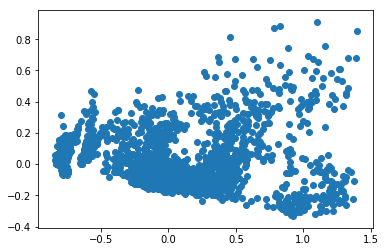

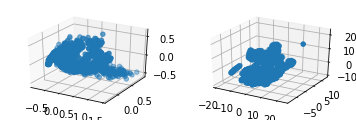

In [88]:
# RepeatVector(time_steps)(encoded) #repeat output 'timestep' times so that it can be constructed as input of decoder
# np.shape(train_x)
# decoded
# from skimage.util.shape import view_as_windows
# b = np.array([[]])
# for i in range(test_sample):
#     b = np.append(b, test_historic_label[i : time_steps + i])
# c = b.reshape(test_sample, time_steps, 1)
# d = view_as_windows(test_historic_label, (time_steps,1))
# print (np.shape(test_historic_label), c.shape, d.shape)
# print (c[:20], " ------ \r\n ----", d[time_steps :time_steps+20])
# data_dim
# train_x.shape
# encoded.shape
# sequence_autoencoder.output_shape
# RepeatVector(time_steps)(encoded)
# compressed_data.shape #repeated 
# dataset.shape
from sklearn.decomposition import PCA
kpca = KernelPCA(n_components=3)
X_new = kpca.fit_transform(dataset)
plt.scatter(X_new[:, 0], X_new[:, 1],marker='o')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure()
# ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
ax = fig.add_subplot(221, projection='3d')
ax.scatter(X_new[:, 0], X_new[:, 1], X_new[:,2],marker='o',cmap=plt.cm.Spectral)  #只能画散点图，不能画平面图，因为第3维不是前两维度的函数z=x2 + y2
pca.get_precision()
pca.score(dataset)

from sklearn import manifold
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
Y = tsne.fit_transform(dataset)

ax = fig.add_subplot(222, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:,2],marker='o',cmap=plt.cm.Spectral) 
plt.show()

In [78]:
inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

## 记录降维效果
#  0s - loss: 0.0598 - mean_absolute_error: 0.1012 - val_loss: 0.0983 - val_mean_absolute_error: 0.1851 （最原始，非记忆）
#  (多加一层) 4层
#  0s - loss: 0.0551 - mean_absolute_error: 0.0828 - val_loss: 0.0916 - val_mean_absolute_error: 0.1591
# Params:  time_steps: 4  latent_dim: 5  batch_size:  20  n_epoch:  50
#  1s - loss: 0.0482 - mean_absolute_error: 0.0734 - val_loss: 0.0877 - val_mean_absolute_error: 0.1579（第一层多加10个神经元）
# Params:  time_steps: 4  latent_dim: 5  batch_size:  20  n_epoch:  50
#  (多加一层) 共6 层
# 1s - loss: 0.0614 - mean_absolute_error: 0.1075 - val_loss: 0.1069 - val_mean_absolute_error: 0.2095
# Params:  time_steps: 4  latent_dim: 5  batch_size:  20  n_epoch:  50
#  1s - loss: 0.0536 - mean_absolute_error: 0.0785 - val_loss: 0.0916 - val_mean_absolute_error: 0.1587 (多50个epoch)
#  Params:  time_steps: 4  latent_dim: 5  batch_size:  20  n_epoch:  100 （效果跟不加1层，训练50个epoch一个效果）
#   0s - loss: 0.0494 - mean_absolute_error: 0.0741 - val_loss: 0.0878 - val_mean_absolute_error: 0.1622 （少2层）
#  Params:  time_steps: 4  latent_dim: 5  batch_size:  20  n_epoch:  100
# 修正decoder层数，神经元更改至20-10-5
# 1s - loss: 0.0537 - mean_absolute_error: 0.0772 - val_loss: 0.0928 - val_mean_absolute_error: 0.1649
# Params:  time_steps: 4  latent_dim: 5  batch_size:  20  n_epoch:  100 

# Timestep 增加1倍，MAE提高一点
#  0s - loss: 0.0521 - mean_absolute_error: 0.0905 - val_loss: 0.0951 - val_mean_absolute_error: 0.1728 单层模型
# Params:  time_steps: 8  latent_dim: 5  batch_size:  20  n_epoch:  100
# - loss: 0.0523 - mean_absolute_error: 0.0706 - val_loss: 0.0898 - val_mean_absolute_error: 0.1441 同一个模型减少timestep
# Params:  time_steps: 2  latent_dim: 5  batch_size:  20  n_epoch:  100
# 2s - loss: 0.0560 - mean_absolute_error: 0.0832 - val_loss: 0.0961 - val_mean_absolute_error: 0.1717 多层模型 效果略好
# Params:  time_steps: 8  latent_dim: 5  batch_size:  20  n_epoch:  100
# - loss: 0.0581 - mean_absolute_error: 0.0868 - val_loss: 0.1007 - val_mean_absolute_error: 0.1801 同一个模型减少timestep
# Params:  time_steps: 2  latent_dim: 5  batch_size:  20  n_epoch:  100
#  9s - loss: 0.0756 - mean_absolute_error: 0.1089 - val_loss: 0.1186 - val_mean_absolute_error: 0.2251 TS增加反而下降
# Params:  time_steps: 50  latent_dim: 5  batch_size:  20  n_epoch:  100

## 画图
# 0s - loss: 0.0636 - mean_absolute_error: 0.0834 - val_loss: 0.1039 - val_mean_absolute_error: 0.1607 跑100次，TS=1可分
# Params:  time_steps: 1  latent_dim: 3  batch_size:  20  n_epoch:  100
# 
# QUTUR连接实验
#  1s - loss: 0.0169 - mean_absolute_error: 0.0569 - val_loss: 0.0479 - val_mean_absolute_error: 0.1473 50次，TS=8
#  Params:  time_steps: 8  latent_dim: 8  batch_size:  20  n_epoch:  50

## 去掉历史标签
#  - 0s - loss: 0.0043 - mean_absolute_error: 0.0416 - val_loss: 0.0305 - val_mean_absolute_error: 0.1171
# Params:  time_steps: 8  compressed_dim: 8  batch_size:  20  n_epoch_ae:  50

array([[-0.06664673,  0.10888751],
       [-0.03922827,  0.08370271],
       [-0.05986158,  0.10077295],
       ..., 
       [-0.09428188,  0.04080769],
       [-0.09503774,  0.05905358],
       [-0.11878381,  0.0663715 ]])

In [ ]:
print('Avg. Train ACC = ', np.average(history.history['acc']))
print('Avg. Test ACC = ', np.average(history.history['val_acc']))

In [12]:


## drawing compressed data
plt.scatter(compressed_data[:, 0], compressed_data[:, 1],marker='.')
plt.show()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(compressed_data[:, 0], compressed_data[:, 1], compressed_data[:,2],marker='o', c= 'r')

AttributeError: 'NoneType' object has no attribute 'sqrt'